In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Kmeans Clustering for Satellite Imagery


Recently, I applied Kmeans clustering to Satellite Imagery and was fairly impressed by the results. I'll tell you the tricks I learned so you don't waste your time. 


![img](https://drive.google.com/uc?id=1z88hItdZYNJhjECbJorWVpcUq9bB-Guv)


Things to note:

- Use [rasterio]() not [gdal](). Gdal [sucks](https://www.reddit.com/r/gis/comments/4tltus/a_rant_gis_software_sucks/).

- I will be using Terravion imagery. This gives high resolution low level satellite imagery. The Terravion imagery comes in 8 different bands (`alpha`, `blue`, `green`, `green2`, `nir`, `red`, `red2`, `tirs`)

- I'll have 3 clusters. These will include:
  - Canopy cover (trees, vegetation, etc. ) 
  - Soil
  - Background 









In [12]:
!pip install rasterio
import shutil
import glob
import zipfile
import os
import PIL
from pathlib import Path
from datetime import datetime
import rasterio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Kmeans Explanation
I made an infographic to explain how Kmeans works. Check it out on [reddit](https://www.reddit.com/r/learnmachinelearning/comments/kipra3/i_made_an_infographic_to_summarise_kmeans/).

Here's a small version:

<center>
<img src="https://drive.google.com/uc?id=17h24B0poX9GOywYu2xaqoMsXo3E0gLkr" align="center" width="300" />
</center>

# Prep Dataset

This cell will copy across `.zip` files for Terrav data from google drive. 


Once they are manually uploaded run the cells here.

In [13]:
%cd /content/

# copying over: 
# - canopy_cover_cotton_ea36717ca661ca3cca59d5ea43a81afc_20190502T113544_TERRAV_PLN.zip
# - canopy_cover_cotton_ea36717ca661ca3cca59d5ea43a81afc_20190404T121854_TERRAV_PLN.zip

# function to create directory
def create_directory(directory_name):
	name = os.getcwd()+'/'+str(directory_name)
	try:
		os.makedirs(name)    
	except FileExistsError:
		shutil.rmtree(name)

zip_files = glob.glob('/content/drive/MyDrive/canopy_cover_cotton_*.zip')
for i in range(len(zip_files)):

  file = zip_files[i]
  folder = file.split('/')[-1].split('.')[0]
  path_to_zip_file = '/content/'+folder+'/zip_file.zip'
  directory_to_extract_to = '/content/'+folder+'/'
  # print(file)
  # print(folder)
  # print(path_to_zip_file)
  create_directory(folder)
  shutil.copyfile(file, path_to_zip_file)
  with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(directory_to_extract_to)
  os.remove(path_to_zip_file)


/content


FileNotFoundError: ignored

# Helper functions

In [11]:
from math import ceil
from io import BytesIO
import IPython.display

# taken from stylegan
def createImageGrid(images, scale=0.25, rows=1):
  w,h = images[0].size
  w = int(w*scale)
  h = int(h*scale)
  height = rows*h
  cols = ceil(len(images) / rows)
  width = cols*w
  canvas = PIL.Image.new('RGBA', (width,height), 'white')
  for i,img in enumerate(images):
    img = img.resize((w,h), PIL.Image.ANTIALIAS)
    canvas.paste(img, (w*(i % cols), h*(i // cols))) 
  return canvas

# taken from stylegan 
def imshow_func(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
            'trying jpeg instead.').format(format)
      return imshow_func(a, format='jpeg')
    else:
      raise
  return disp

# Stack Bands

Your Terravion may look like the following:

 - `red2.tif`
 - `alpha.tif`
 - `tirs.tif`
 - `blue.tif`
 - `nir.tif`
 - `red.tif`
 - `green.tif`
 - `green2.tif`

You'll need to stack all the bands before doing anything with these files. Here's some code for stacking the bands. It was taken from [this post](https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands)


In [ ]:
def stack_bands(files):
  img_fp = 'sentinel_bands.tif'
  # Read metadata of first file and assume all other bands are the same
  with rasterio.open(files[0]) as src0:
      meta = src0.meta

  # Update metadata to reflect the number of layers
  meta.update(count = len(files))

  # Read each layer and write it to stack
  with rasterio.open(img_fp, 'w', **meta) as dst:
      for id, layer in enumerate(files, start=1):
          with rasterio.open(layer) as srclassifer:
              dst.write_band(id, srclassifer.read(1))

  return img_fp

# Get Combinations

In [36]:
combinations = glob.glob('/content/canopy_cover*TERRAV*')
combinations = ['_'.join(os.path.basename(i).split('_')[3:5]) for i in combinations]
combinations

['9bbd67cfb0d660551d74decf916b2df2_20190223T130237',
 '9bbd67cfb0d660551d74decf916b2df2_20190502T113205',
 'ea36717ca661ca3cca59d5ea43a81afc_20190404T121854',
 'ea36717ca661ca3cca59d5ea43a81afc_20190304T163719',
 '9bbd67cfb0d660551d74decf916b2df2_20190404T121333',
 '6002cdd6eefa28d66cd6cf83c81973a8_20190304T164059',
 '6002cdd6eefa28d66cd6cf83c81973a8_20190415T123518',
 '9bbd67cfb0d660551d74decf916b2df2_20190304T164648',
 '6002cdd6eefa28d66cd6cf83c81973a8_20190502T113521',
 '6002cdd6eefa28d66cd6cf83c81973a8_20190505T073019',
 '6002cdd6eefa28d66cd6cf83c81973a8_20190223T130709',
 'ea36717ca661ca3cca59d5ea43a81afc_20190502T113544',
 'ea36717ca661ca3cca59d5ea43a81afc_20190325T115312',
 '9bbd67cfb0d660551d74decf916b2df2_20190304T162316',
 '9bbd67cfb0d660551d74decf916b2df2_20190325T124651',
 '6002cdd6eefa28d66cd6cf83c81973a8_20190404T121843']

In [37]:
# remove 6002cdd6eefa28d66cd6cf83c81973a8_20190404T121843
combinations = [i for i in combinations if '6002cdd6eefa28d66cd6cf83c81973a8' not in i]
combinations

['9bbd67cfb0d660551d74decf916b2df2_20190223T130237',
 '9bbd67cfb0d660551d74decf916b2df2_20190502T113205',
 'ea36717ca661ca3cca59d5ea43a81afc_20190404T121854',
 'ea36717ca661ca3cca59d5ea43a81afc_20190304T163719',
 '9bbd67cfb0d660551d74decf916b2df2_20190404T121333',
 '9bbd67cfb0d660551d74decf916b2df2_20190304T164648',
 'ea36717ca661ca3cca59d5ea43a81afc_20190502T113544',
 'ea36717ca661ca3cca59d5ea43a81afc_20190325T115312',
 '9bbd67cfb0d660551d74decf916b2df2_20190304T162316',
 '9bbd67cfb0d660551d74decf916b2df2_20190325T124651']

sort by dates

In [38]:
sorted_combinations = sorted(combinations, key = lambda text: \
                                          (os.path.basename(text).split('.')[0].split('_')[-2],\
                                           datetime.strptime(os.path.basename(text).split('.')[0].split('_')[-1], '%Y%m%dT%H%M%S').date()))

sorted_combinations

['9bbd67cfb0d660551d74decf916b2df2_20190223T130237',
 '9bbd67cfb0d660551d74decf916b2df2_20190304T164648',
 '9bbd67cfb0d660551d74decf916b2df2_20190304T162316',
 '9bbd67cfb0d660551d74decf916b2df2_20190325T124651',
 '9bbd67cfb0d660551d74decf916b2df2_20190404T121333',
 '9bbd67cfb0d660551d74decf916b2df2_20190502T113205',
 'ea36717ca661ca3cca59d5ea43a81afc_20190304T163719',
 'ea36717ca661ca3cca59d5ea43a81afc_20190325T115312',
 'ea36717ca661ca3cca59d5ea43a81afc_20190404T121854',
 'ea36717ca661ca3cca59d5ea43a81afc_20190502T113544']

In [15]:
# remove folder and recreate
if(os.path.exists('kmeans_output')): shutil.rmtree('kmeans_output')
os.mkdir('kmeans_output')

# Fit Kmeans

Now we'll need to fit the kmeans classifier to the data. What I found worked best was fitting the Kmeans classifier on a few images. Ideally images with a distinct difference between canopy cover and soil.

The `train` function will take in a md5 code (eg. `9bbd67cfb0d660551d74decf916b2df2`) and a date string (eg. `20190223T130237`). It will find that image on the dataset and fit the kmeans classifier on that image. 

I've made a few helper functions here to get the appropriate files. 

A few important things:

- I'm not using the `alpha` and `blue` channels. They proved to be useless. 

- I'm using `red2.tif` and `green2.tif`. `red.tif` and `green.tif` didn't help as much.

Much of this training code was adapted from this [github repo](https://github.com/wathela/Sentinel2-clustering/blob/master/Sentinel2_Image_clustering.ipynb).

In [ ]:
from sklearn.cluster import KMeans
from rasterio.plot import reshape_as_image
import matplotlib.cm as cm
from sklearn import cluster

def get_date_from_text(text):
  text = text.split('/')[-2].split('_')[4]
  datetime_date = datetime.strptime(text, '%Y%m%dT%H%M%S').date()
  return datetime_date

# no alpha and blue imgs
def get_files_from_code(code, date):
  files = glob.glob('/content/canopy_cover_cotton_*'+code+'_'+date+'*TERRAV_PLN/*.tif')
  files = sorted(files, key = lambda x: get_date_from_text(x))
  files = [i for i in files if os.path.basename(i).split('.')[0] in ('red2', 'green2', 'nir', 'tirs')]
  return files

def train(k = 3, classifer = None, date = '20190223T130237', code = '9bbd67cfb0d660551d74decf916b2df2'):

  files = get_files_from_code(code, date)

  img_fp = stack_bands(files)
  img_raster = rasterio.open(img_fp)

  # Read, enhance and show the image
  img_arr = img_raster.read()
  vmin, vmax = np.nanpercentile(img_arr, (5,95))  # 5-95% contrast stretch

  # create an empty array with same dimension and data type
  imgxyb = np.empty((img_raster.height, img_raster.width, img_raster.count), img_raster.meta['dtype'])

  # loop through the raster's bands to fill the empty array
  for band in range(imgxyb.shape[2]):
      imgxyb[:,:,band] = img_raster.read(band+1)

  # convet to 1d array. 4 cause we have 4 bands here.
  img1d = imgxyb[:,:,:4].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
  # print(img1d.shape)

  # create an object of the classifier and train it
  if(classifer == None):
    classifer = cluster.KMeans(n_clusters=k)
  # param = cl.fit(img1d[~mask])
  param = classifer.fit(img1d)

  # get the labels of the classes and reshape it x-y-bands shape order (one band only)
  img_cl = classifer.labels_
  img_cl = img_cl.reshape(imgxyb[:,:,0].shape)

  # Show the resulting array and save it as jpg image
  plt.figure()
  plt.imshow(img_cl, cmap=cm.YlOrRd)
  plt.axis('off')
  plt.savefig("kmeans_train_image.jpg", bbox_inches='tight')
  plt.show()

  return classifer


In [ ]:
# train model
train_dates = ['20190502T113544', '20190502T113205']
train_codes = ['ea36717ca661ca3cca59d5ea43a81afc', '9bbd67cfb0d660551d74decf916b2df2']
model = None

for i in range(min(len(train_codes), len(train_dates))):
  model = train(classifer = model, date = train_dates[i], code = train_codes[i])


# Prediction

Now we can run predictions on our new model and see how it does. 

This function will take in the stacked bands and predict from the `model`. It will save the prediction image and the original image in a folder called `kmeans_output`. 

These saved images are for visualisation purposes only. Don't use them for further calculations (I accidentally did that and got very confused). 

In [ ]:
from tqdm.notebook import tqdm

def get_date_from_orig_image(text):
  text = os.path.basename(text).split('.')[0].split('_')[-1]
  datetime_date = datetime.strptime(text, '%Y%m%dT%H%M%S').date()
  return datetime_date

def get_orig_img_list(code, date):
  original_images = glob.glob('/content/drive/My Drive/flurosat/*'+code+'_'+date+'*.*g')
  original_images = sorted(original_images, key = lambda x: get_date_from_orig_image(x))
  return original_images[0]

# predict using new k means method
def predict(model, img_fp):

  elmanagel = rasterio.open(img_fp)

  # Read, enhance and show the image
  elman_arr = elmanagel.read()
  vmin, vmax = np.nanpercentile(elman_arr, (5,95))  # 5-95% contrast stretch

  # create an empty array with same dimensions and data type 
  elman_xyb = np.empty((elmanagel.height, elmanagel.width,elmanagel.count), elmanagel.meta['dtype'])

  # loop through the raster bands and fill the empty array in x-y-bands order
  for band in range(elman_xyb.shape[2]):
      elman_xyb[:,:,band] = elmanagel.read(band+1)

  # convert to 1d array
  elman_1d = elman_xyb[:,:,:elman_xyb.shape[2]].reshape(elman_xyb.shape[0]*elman_xyb.shape[1], elman_xyb.shape[2])

  # predict the clusters in the image 
  pred = model.predict(elman_1d)

  # reshape the 1d array predictions to x-y-bands shape order (only one band)
  elman_cul = pred
  elman_cul = elman_cul.reshape(elman_xyb[:,:,0].shape)

  return elman_cul

def predictions_driver(code, date, iterations):

  files = get_files_from_code(code, date)
  original_image = get_orig_img_list(code, date)

  # # rasterio stack all bands
  img_fp = stack_bands(files)

  # predict on trained model
  kmeans_predictions = predict(model, img_fp)

  # save kmeans
  plt.imsave('kmeans_output/'+str(code)+'_'+str(iterations)+'_k_means.jpg', kmeans_predictions, cmap=cm.YlOrRd)

  # save original image
  img = PIL.Image.open(original_image)
  img.save('kmeans_output/'+str(code)+'_'+str(iterations)+'_original_image.jpg')

  return

for i,combination in enumerate(tqdm(sorted_combinations)):
  date = combination.split('_')[-1]
  code = combination.split('_')[0]
  predictions_driver(code, date, i)


# Create Grid

Now we can create an image grid from the saved images we got previously.

This makes it far easier to see if Kmeans was actually correct.

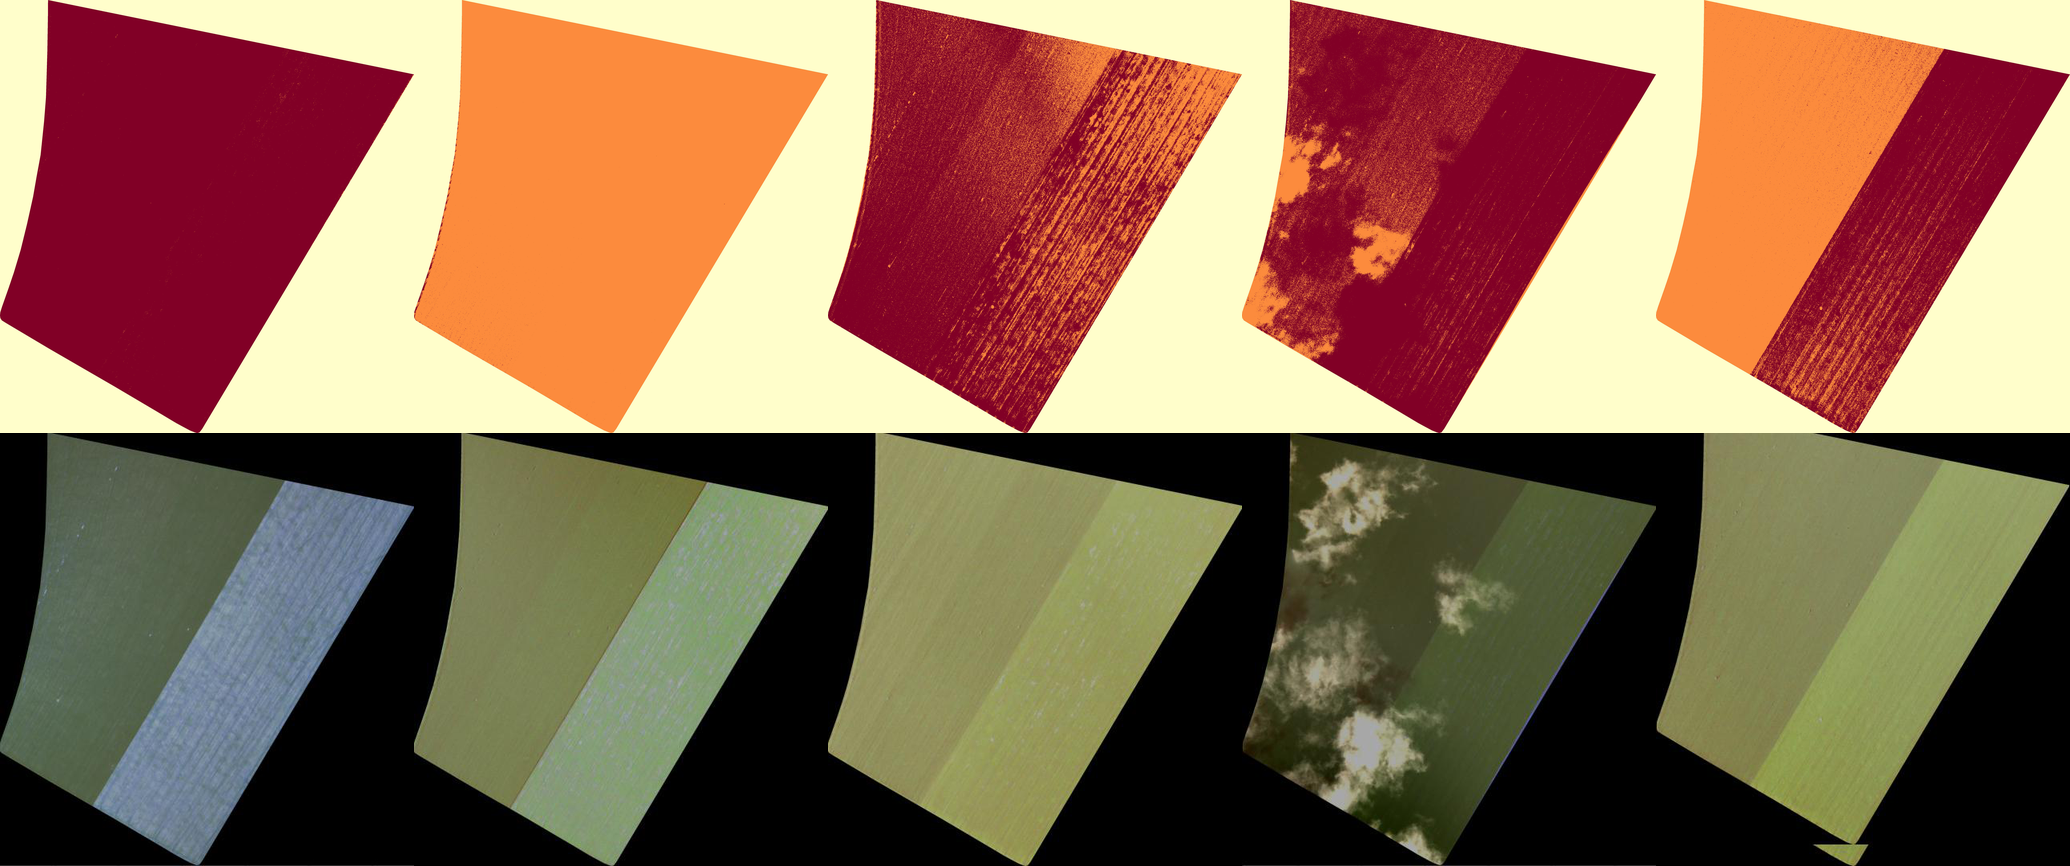

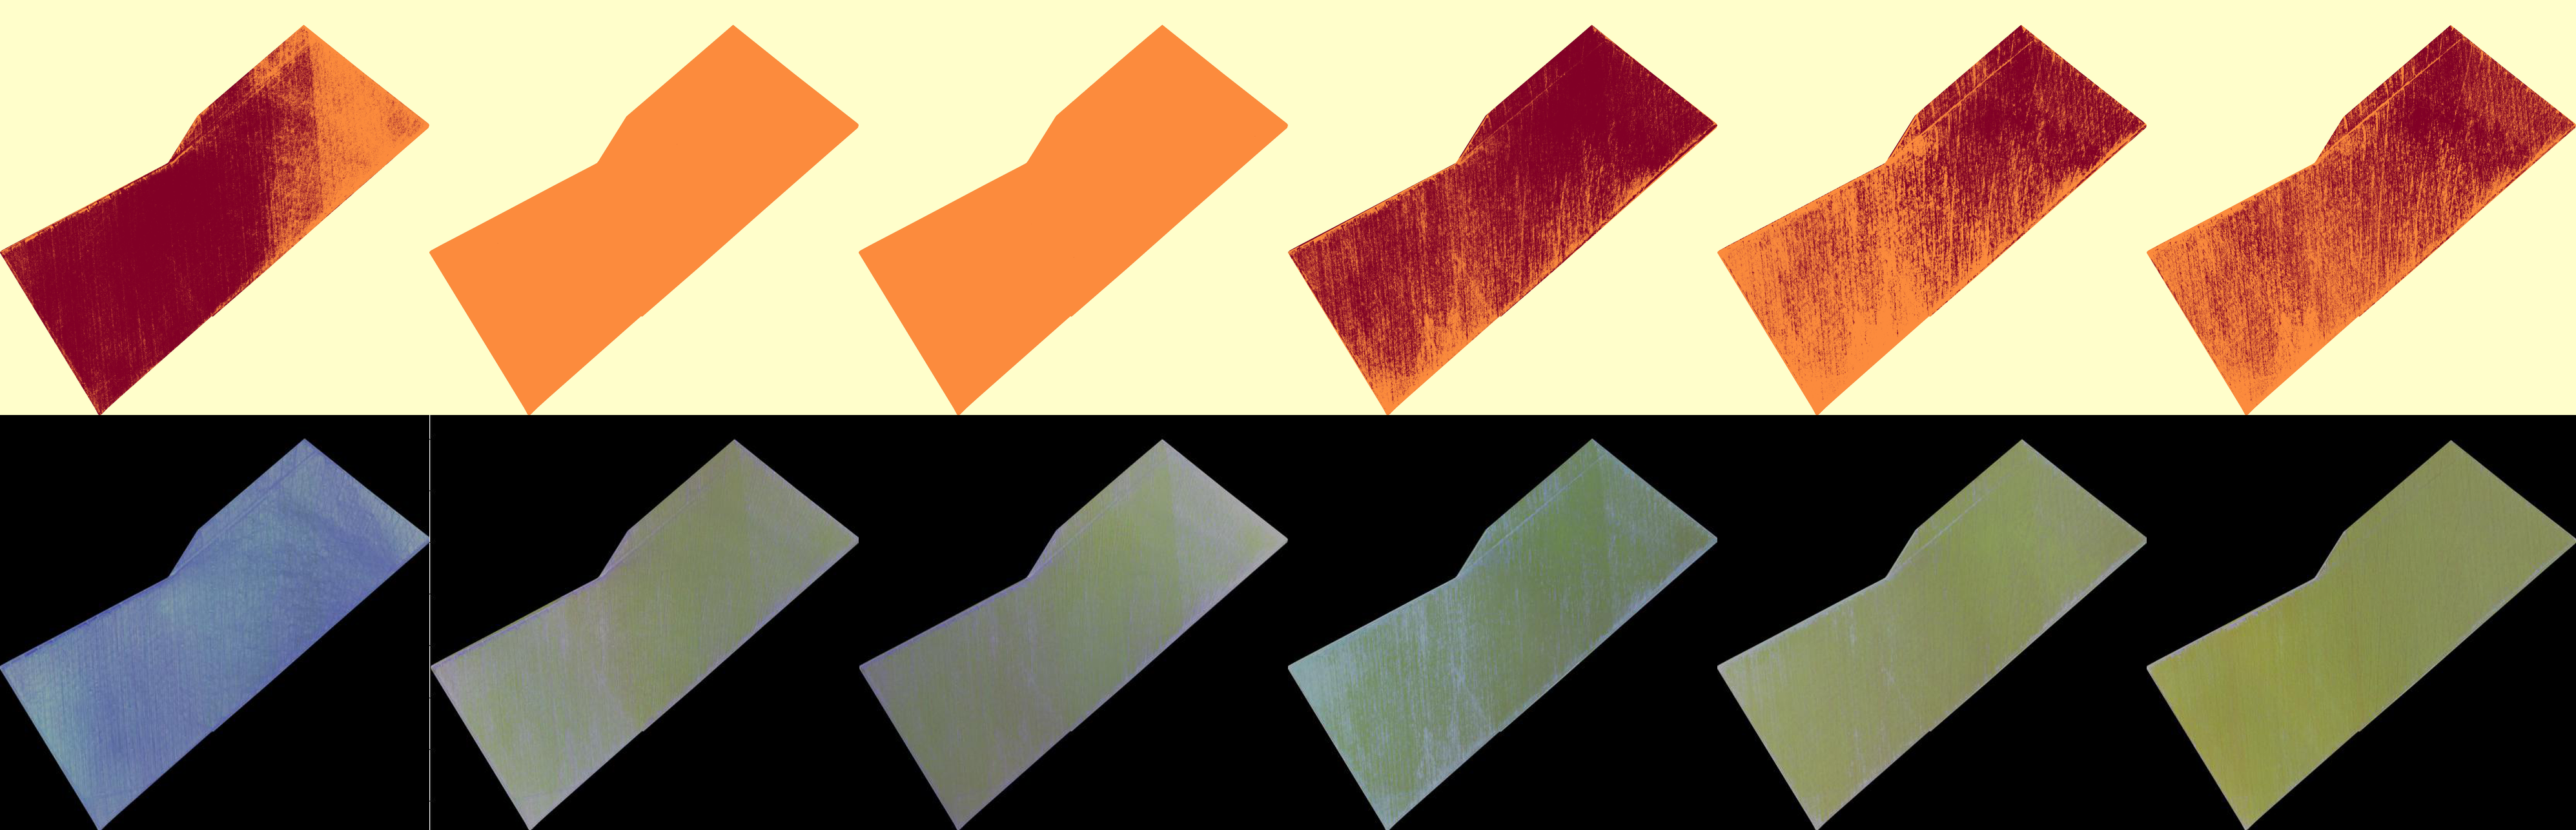

In [ ]:
codes = list(set([i.split('_')[0] for i in combinations]))

for code in codes:

  k_means = glob.glob('kmeans_output/*'+str(code)+'*k_means.*g')
  k_means = sorted(k_means, key = lambda x: int(os.path.basename(x).split('.')[0].split('_')[-3]))
  k_means = [PIL.Image.open(i) for i in k_means]

  original_imgs = glob.glob('kmeans_output/*'+str(code)+'*original_image.*g')
  original_imgs = sorted(original_imgs, key = lambda x: int(os.path.basename(x).split('.')[0].split('_')[-3]))
  original_imgs = [PIL.Image.open(i) for i in original_imgs]
  
  full_list = k_means + original_imgs
  imshow_func(createImageGrid(full_list, rows = 2, scale = 0.1))


![img](https://drive.google.com/uc?id=1MH49lYuDTjAqmbd4AabDRtTx_txvJ0R4)



# Conclusion

I did this work for a [small startup in Sydney](https://flurosat.com/). I learned so much for the experienced professionals at this startup. I couldn't have created this without their help. 

I hope this post helps someone out there. It certaintly would've helped me when I started. The full code can be found on Github

If I've made a mistake please reach out to me on [twitter](https://twitter.com/neeliyer11)